# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


import tensorflow as tf
tf.version.VERSION
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

2024-05-19 23:03:37.161053: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 23:03:37.185245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 23:03:37.550758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from functions import momentos, gauss, gauss_fit, normalize_by_max, simpsons_rule_array, get_mean_pulse_from_set, delay_pulse_pair, move_to_reference

# **LOAD PULSES**

In [3]:
Nev_Co60 = 200000  #Nùmero de eventos en las prácticas del máster
Nev_Na22 = 150000
Nt = 600
Nc = 2

In [4]:
#pulsos_Na22 = np.zeros((Nev_Na22,Nt,Nc))
#
#
#with open('/home/josea/PracticaTimingDigital/pulsoNa22', 'rb') as file:
#  for i in range(Nev_Na22):
#    for j in range(Nt):
#      try:
#        pulsos_Na22[i,j, :] = np.fromfile(file, dtype=np.float32, count = 2)
#      except EOFError:
#        break
#
#    a1, a2 = np.fromfile(file, dtype=np.float32, count=2)

In [5]:
#np.savez_compressed('/home/josea/PracticaTimingDigital/pulsoNa22', data=pulsos_Na22)

In [6]:
data = np.load('/home/josea/PracticaTimingDigital/pulsoNa22_filt_norm.npz')
pulsos_Na22_filt_norm = data['data']

# **PREPROCESSING**

## **ENERGY FILTERING**

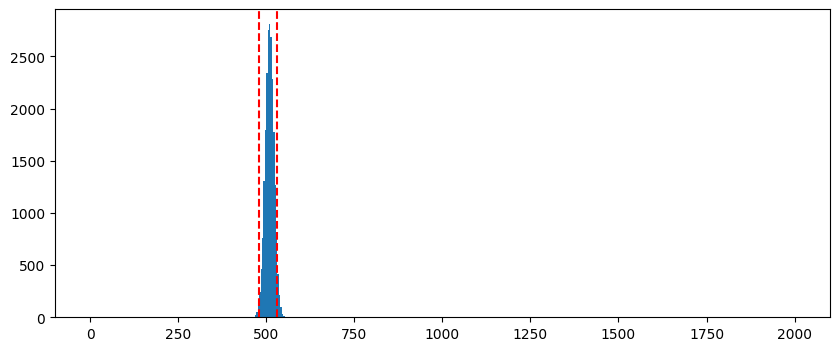

In [7]:
from scipy.signal import find_peaks

energy_dec0 = simpsons_rule_array(pulsos_Na22_filt_norm[:,50:550,0],1)

histogE, binsE = np.histogram(energy_dec0,bins=500,range=[0,200]);
index = find_peaks(histogE, height=1000)[0][-1]
m = 511/((binsE[index+1]+binsE[index])/2)
calibrado_dec0 = m*energy_dec0


gate_min_dec0 = 480
gate_max_dec0 = 530
plt.figure(figsize=(10,4))
plt.hist(calibrado_dec0,bins = 500, range = [0,2000]);
plt.axvline(x=gate_min_dec0, color='r', linestyle='--')
plt.axvline(x=gate_max_dec0, color='r', linestyle='--')

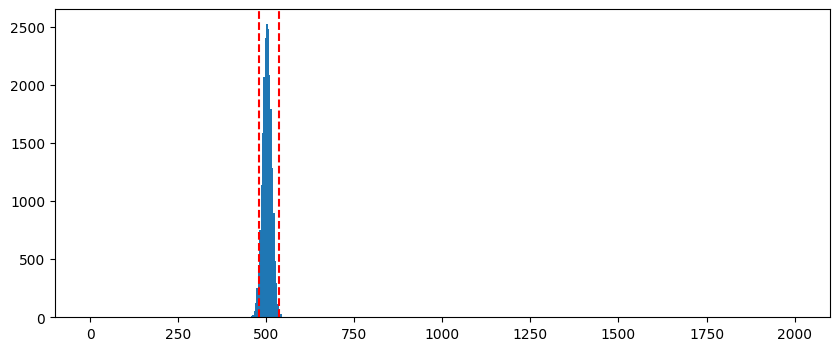

In [8]:
energy_dec1 = simpsons_rule_array(pulsos_Na22_filt_norm[(calibrado_dec0>gate_min_dec0)  & (calibrado_dec0<gate_max_dec0),:,1],1)

histogE, binsE = np.histogram(energy_dec1,bins=500,range=[0,200]);
index = find_peaks(histogE, height=200)[0][-1]
m = 511/((binsE[index+1]+binsE[index])/2)
calibrado_dec1 = m*energy_dec1


gate_min_dec1 = 480
gate_max_dec1 = 535
plt.figure(figsize=(10,4))
plt.hist(calibrado_dec1,bins=500, range = [0,2000])
plt.axvline(x=gate_min_dec1, color='r', linestyle='--')
plt.axvline(x=gate_max_dec1, color='r', linestyle='--')

In [9]:
pulsos_Na22_filt = pulsos_Na22[(calibrado_dec0>gate_min_dec0)  & (calibrado_dec0<gate_max_dec0),:,:]
pulsos_Na22_filt = pulsos_Na22_filt[(calibrado_dec1>gate_min_dec1)  & (calibrado_dec1<gate_max_dec1),:,:]
print(pulsos_Na22_filt.shape)

#------------------------------------------------------- Normalizar Pulsos ------------------------------------------------------------------------------------
pulsos_Na22_filt_norm = normalize_by_max(pulsos_Na22_filt)

NameError: name 'pulsos_Na22' is not defined

## **CHECK FOR OUTLIERS**

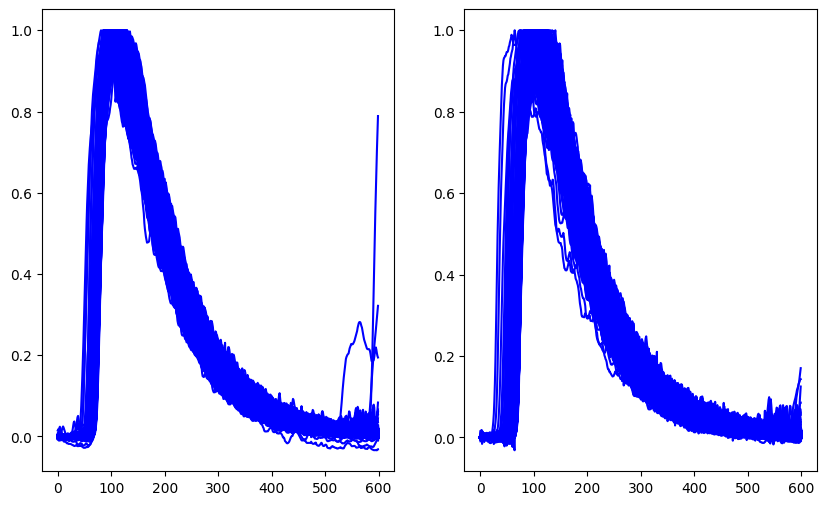

In [10]:
#pulsos_Na22_filt_norm = np.delete(pulsos_Na22_filt_norm, [ 4409, 16795, 19407, 9901, 13290], axis=0)

#------------------------------------ Con el plot se ve si hay algún pulso que empiece mal/que no cuadre con el otro detector
a = []
plt.figure(figsize=(10,6))
for i in range(pulsos_Na22_filt_norm.shape[0]):
  plt.subplot(121)
  plt.plot(pulsos_Na22_filt_norm[i,:,0], 'b-')
  plt.subplot(122)
  plt.plot(pulsos_Na22_filt_norm[i,:,1], 'b-')
  a.append(np.where(pulsos_Na22_filt_norm[i,:,0] == np.max(pulsos_Na22_filt_norm[i,:,0]))[0][0])
a = np.array(a)

## **INTERPOLATE**

In [11]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = pulsos_Na22_filt_norm
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func = interp1d(tiempo,pulsos_Na22_filt_norm,  kind='cubic', axis=1)
new_pulses = interp_func(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

#-------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulses[:,:,1] = np.roll(new_pulses[:,:,1], align_steps)
new_pulses[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)


Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


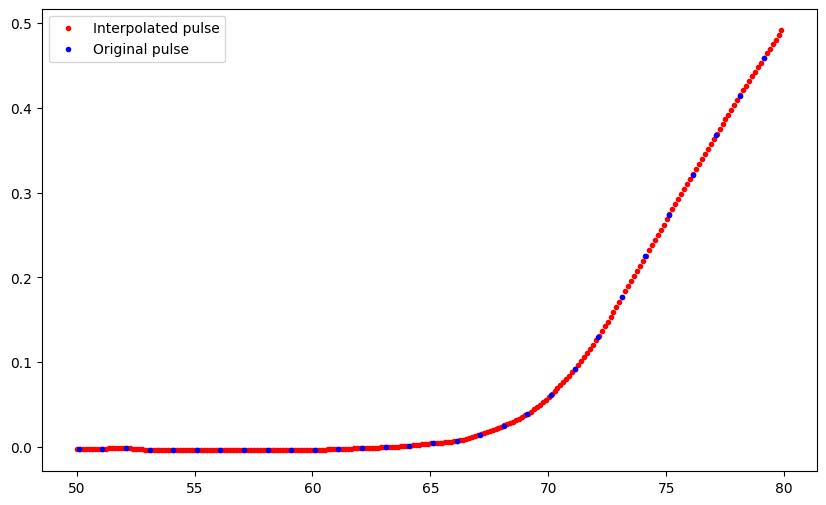

In [12]:
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

plt.figure(figsize=(10,6))

t_new = np.linspace(0,Nt,Nt_new)
t = np.linspace(0,Nt,Nt)
plt.plot(t_new[start:stop],new_pulses[0,start:stop,0],'r.')
plt.plot(t[50:80],pulsos_Na22_filt_norm[0,50:80,0],'b.')
plt.legend(('Interpolated pulse','Original pulse'))

In [13]:
#------------------------------------- Define size of train set ---------------------------------
Ntrain = int(0.8*new_pulses.shape[0])

# **DETECTOR 0**

In [14]:
#-------------------------------------- Calculate mean pulse in detector ----------------------------------
mean_dec0 = get_mean_pulse_from_set(new_pulses, channel = 0)

#------------------------------------- Move rest of the pulses to align with mean ------------------------- 
delays_dec0, moved_pulses_dec0 = move_to_reference(mean_dec0, new_pulses[:Ntrain,:,:], start = start, stop = stop, max_delay = 240, channel = 0)

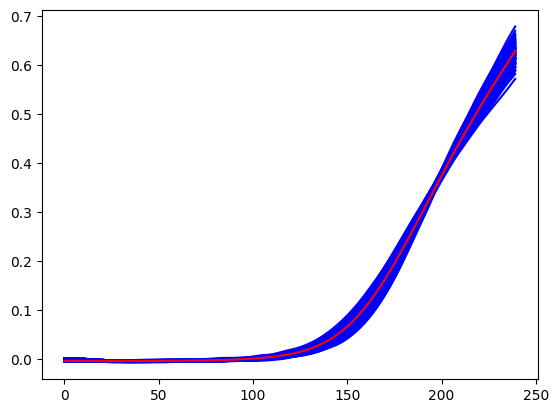

In [15]:
for i in range(100):
    plt.plot(moved_pulses_dec0[i,:],'b-')
plt.plot(mean_dec0[start:stop],'r-')

In [16]:
#------------------------ Create pairs of detector 0 pulses --------------------------------------
Input_dec0 = np.zeros((moved_pulses_dec0.shape[0], moved_pulses_dec0.shape[1], 2))
Input_dec0[:,:,0] = moved_pulses_dec0[:,:]
Input_dec0[:,:,1] = moved_pulses_dec0[:,:]

#-------------------------------- Create train set --------------------------------------------
trainX_dec0, REF_train_dec0 = delay_pulse_pair(Input_dec0, new_time_step, t_shift = 0, delay_steps = 20, NOISE = True)

In [17]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)


NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min dec 0: ', min_dec0)
print('Max dec 0: ', max_dec0)

(17780, 12, 2) NM = 12
Min dec 0:  0.6173550225017623
Max dec 0:  34.29134061440897


# **DETECTOR 1**

In [18]:
#-------------------------------------- Calculate mean pulse in detector ----------------------------------
mean_dec1 = get_mean_pulse_from_set(new_pulses, channel = 1)

#------------------------------------- Move rest of the pulses to align with mean ------------------------- 
delays_dec1, moved_pulses_dec1 = move_to_reference(mean_dec1, new_pulses[:Ntrain,:,:], start = start, stop = stop, max_delay = 240, channel = 1)

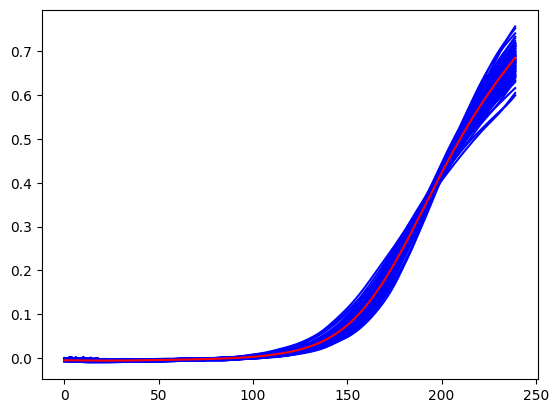

In [19]:
for i in range(100):
    plt.plot(moved_pulses_dec1[i,:],'b-')
plt.plot(mean_dec1[start:stop],'r-')

In [20]:
#------------------------ Create pairs of detector 0 pulses --------------------------------------
Input_dec1 = np.zeros((moved_pulses_dec1.shape[0], moved_pulses_dec1.shape[1], 2))
Input_dec1[:,:,0] = moved_pulses_dec1[:,:]
Input_dec1[:,:,1] = moved_pulses_dec1[:,:]

#-------------------------------- Create train set --------------------------------------------
trainX_dec1, REF_train_dec1 = delay_pulse_pair(Input_dec1, new_time_step, t_shift = 0, delay_steps = 20, NOISE = True)

In [21]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)


NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min dec 1: ', min_dec1)
print('Max dec 1: ', max_dec1)

(17780, 12, 2) NM = 12
Min dec 1:  0.8350508995179748
Max dec 1:  36.05006109523115


# **NEURAL NETWORK**

In [22]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))

  x1 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x2 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x3 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

# **FULL TOF**

In [23]:
REFERENCE_PULSE_dec0 = np.tile(mean_dec0[start:stop], (new_pulses.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_dec1[start:stop], (new_pulses.shape[0],2,1)).swapaxes(1,2)


M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)


#-------------------------------- Create test set ---------------------------------------------------------
delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_dec0, new_pulses[Ntrain:,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_dec1, new_pulses[Ntrain:,:,:], start = start, stop = stop, max_delay = 240, channel = 1)

TEST = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
print(TEST.shape)
#------------------------------- Create other positions ----------------------------------------------------
t_shift = 8

TEST_02 = np.zeros_like(TEST)
TEST_20 = np.zeros_like(TEST)

for i in range(TEST.shape[0]):
  noise00 = np.random.normal(scale=1e-3, size=t_shift)
  noise0 = np.random.normal(scale=0.01, size=TEST.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  TEST_02[i,:,0] = TEST[i,:,0]
  TEST_02[i,:,1] = np.roll(TEST[i,:,1], t_shift)
  TEST_02[i,:,1] = TEST_02[i,:,1] + smoothed_noise
  TEST_02[i,:t_shift,1] = noise00


for i in range(TEST.shape[0]):
  noise00 = np.random.normal(scale=1e-3, size=t_shift)
  noise0 = np.random.normal(scale=0.01, size=TEST.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  TEST_20[i,:,1] = TEST[i,:,1]
  TEST_20[i,:,0] = np.roll(TEST[i,:,0], t_shift)
  TEST_20[i,:,0] = TEST_20[i,:,0] + smoothed_noise
  TEST_20[i,:t_shift,0] = noise00


M_Test_00 = momentos(TEST)
M_Test_00_norm = np.zeros_like(M_Test_00)
M_Test_00_norm[:,:,0] = (M_Test_00[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_Test_00_norm[:,:,1] = (M_Test_00[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_Test_02 = momentos(TEST_02)
M_Test_02_norm = np.zeros_like(M_Test_02)
M_Test_02_norm[:,:,0] = (M_Test_02[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_Test_02_norm[:,:,1] = (M_Test_02[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_Test_20 = momentos(TEST_20)
M_Test_20_norm = np.zeros_like(M_Test_00)
M_Test_20_norm[:,:,0] = (M_Test_20[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_Test_20_norm[:,:,1] = (M_Test_20[:,:,1] - min_dec1)/(max_dec1-min_dec1)


(4446, 240, 2)


In [ ]:
epochs = 40
num_semillas = 10

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_02_list = []
TOFN_00_list = []
TOFN_20_list = []

for i in range(num_semillas):

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=5e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=5e-3)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_02_epoch = []
  TOFN_00_epoch = []
  TOFN_20_epoch = []

  for epoch in range(epochs):
     
     history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0, epochs = 5, batch_size = 512, verbose=1)
     history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1, epochs = 5, batch_size = 512, verbose=1)

     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

     TOFN_dec0_REF_02 = model_dec0.predict([M_Test_02_norm[:,:,0], M_REF_dec0[:M_Test_02_norm.shape[0],:,0]])
     TOFN_dec1_REF_02 = model_dec1.predict([M_Test_02_norm[:,:,1], M_REF_dec1[:M_Test_02_norm.shape[0],:,0]])

     TOFN_dec0_REF_00 = model_dec0.predict([M_Test_00_norm[:,:,0], M_REF_dec0[:M_Test_00_norm.shape[0],:,0]])
     TOFN_dec1_REF_00 = model_dec1.predict([M_Test_00_norm[:,:,1], M_REF_dec1[:M_Test_00_norm.shape[0],:,0]])

     TOFN_dec0_REF_20 = model_dec0.predict([M_Test_20_norm[:,:,0], M_REF_dec0[:M_Test_20_norm.shape[0],:,0]])
     TOFN_dec1_REF_20 = model_dec1.predict([M_Test_20_norm[:,:,1], M_REF_dec1[:M_Test_20_norm.shape[0],:,0]])
    
    
     TOFN_02 = (np.squeeze(TOFN_dec0_REF_02) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_02) - new_time_step*delays_test_dec1)
     TOFN_00 = (np.squeeze(TOFN_dec0_REF_00) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_00) - new_time_step*delays_test_dec1)
     TOFN_20 = (np.squeeze(TOFN_dec0_REF_20) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_20) - new_time_step*delays_test_dec1)
    
     TOFN_02_epoch.append(TOFN_02)
     TOFN_00_epoch.append(TOFN_00)
     TOFN_20_epoch.append(TOFN_20)


     centroid_02 = np.mean(TOFN_02) - np.mean(TOFN_00)
     centroid_20 = np.mean(TOFN_20) - np.mean(TOFN_00)
     mean_error_centroid = (abs(centroid_02 + 0.2) + abs(centroid_20 - 0.2)) / 2
     mean_std = (np.std(TOFN_02) + np.std(TOFN_00) + np.std(TOFN_20)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_02_list.append(TOFN_02_epoch)
  TOFN_00_list.append(TOFN_00_epoch)
  TOFN_20_list.append(TOFN_20_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_02_array = np.array(TOFN_02_list, dtype = 'object')
TOFN_00_array = np.array(TOFN_00_list, dtype = 'object')
TOFN_20_array = np.array(TOFN_20_list, dtype = 'object')

(array([4]), array([11])) 0.17396146175652033


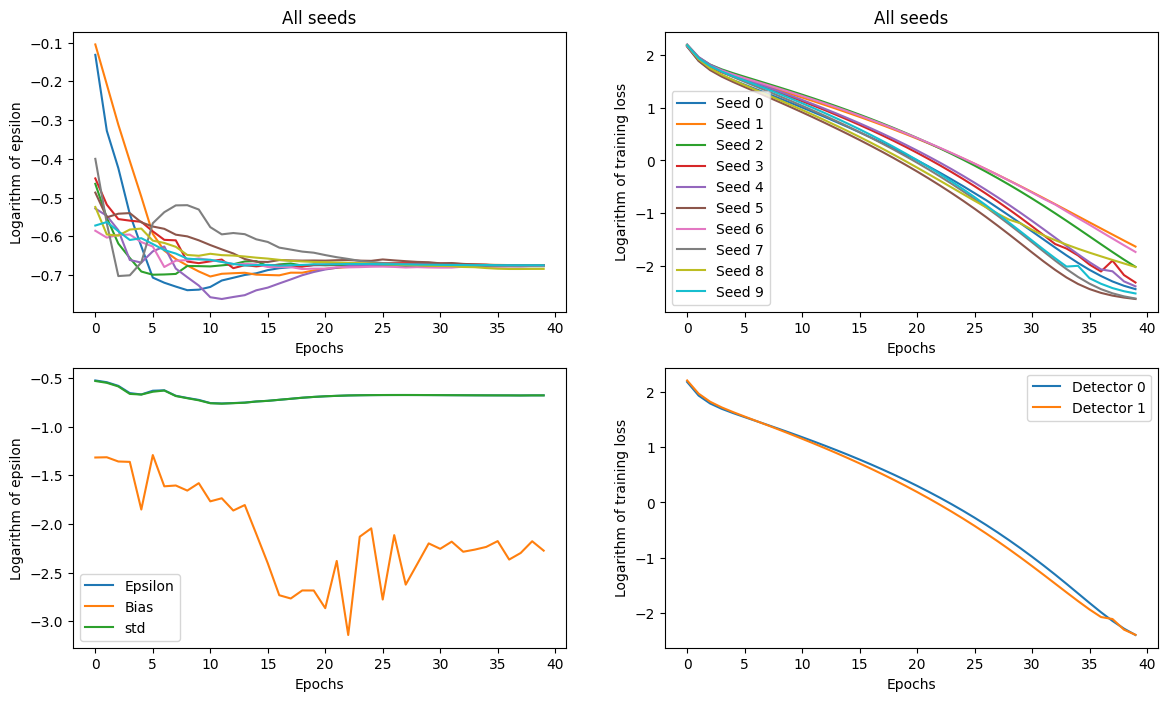

In [30]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 4 
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  #plt.plot(np.log10(epsilon[i,:]))
  plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


02: CENTROID(ns) = -0.219  FWHM(ns) = 0.245  std(ns) = 0.104
00: CENTROID(ns) = -0.003  FWHM(ns) = 0.238  std(ns) = 0.101
20: CENTROID(ns) = 0.217  FWHM(ns) = 0.241  std(ns) = 0.103


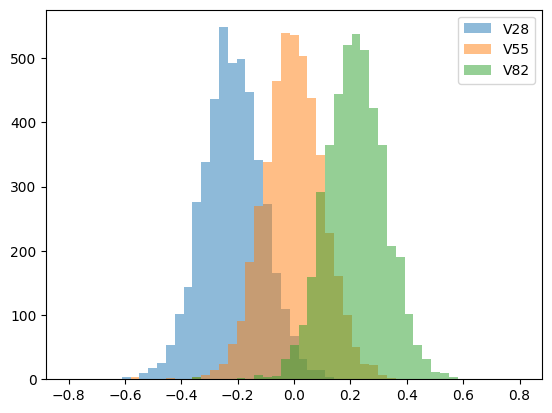

In [31]:
epoch = 11
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_02, binsN, patchesN  = plt.hist(TOFN_02_array[index,epoch,:] - np.mean(TOFN_00_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_02)

histogN, binsN, patchesN  = plt.hist(TOFN_00_array[index,epoch,:] - np.mean(TOFN_00_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)

histogN_20, binsN, patchesN  = plt.hist(TOFN_20_array[index,epoch,:] - np.mean(TOFN_00_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_20)
plt.legend()


FWHMN_02 = 2.35482 * sigmaN_02
FWHMN = 2.35482 * sigmaN
FWHMN_20 = 2.35482 * sigmaN_20


print('')
print("02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N, FWHMN, sigmaN))
print("20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))

# **ENSEMBLE MODEL**

In [27]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_20 = np.average(np.squeeze(TOFN_20_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_00 = np.average(np.squeeze(TOFN_00_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_02 = np.average(np.squeeze(TOFN_02_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


02: CENTROID(ns) = -0.206  FWHM(ns) = 0.442  std(ns) = 0.188
00: CENTROID(ns) = -0.001  FWHM(ns) = 0.427  std(ns) = 0.182
20: CENTROID(ns) = 0.211  FWHM(ns) = 0.426  std(ns) = 0.181


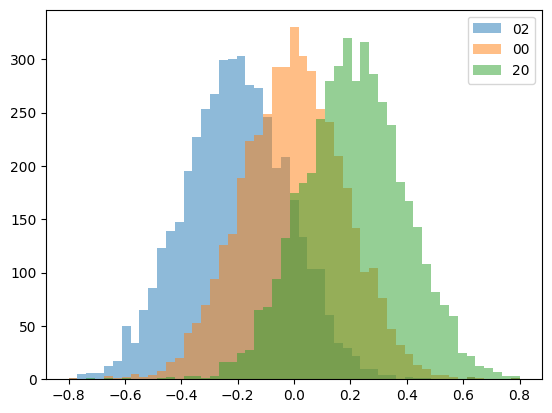

In [28]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_02, binsN, patchesN  = plt.hist(weighted_mean_02 - np.mean(weighted_mean_00),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='02');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_02)

histogN, binsN, patchesN  = plt.hist(weighted_mean_00 - np.mean(weighted_mean_00),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='00');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)

histogN_20, binsN, patchesN  = plt.hist(weighted_mean_20 - np.mean(weighted_mean_00),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='20');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_20)
plt.legend()


FWHMN_02 = 2.35482 * sigmaN_02
FWHMN = 2.35482 * sigmaN
FWHMN_20 = 2.35482 * sigmaN_20


print('')
print("02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N, FWHMN, sigmaN))
print("20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))